In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [8]:
# load in data with relative path
tree_df = pd.read_csv('sample_data/2015_Street_Tree_Census_-_Tree_Data.csv')

In [9]:
# drop columns
tree_df = tree_df.drop(columns=[
    'borocode', 'x_sp', 'y_sp', 'state', 'nta_name', 'zip_city', 'address',
    'spc_latin', 'created_at', 'tree_id', 'block_id', 'user_type', 'bin',
    'bbl', 'council district', 'boro_ct', 'census tract', 'problems', 'status',
    'stump_diam', 'postcode', 'community board', 'cncldist', 'st_assem', 'st_senate', 
    'nta', 'spc_common'
])

# drop NA and dead tree values
tree_df = tree_df[tree_df['health'].notna()]
tree_df = tree_df.dropna(how='any')

#no need for scaling 
# Ordinal Encode
health = ['Poor', 'Fair', 'Good']
enc = OrdinalEncoder(categories=[health])
tree_df['health'] = enc.fit_transform(tree_df[['health']])

steward = ['None', '1or2', '3or4', '4orMore']
enc = OrdinalEncoder(categories=[steward])
tree_df['steward'] = enc.fit_transform(tree_df[['steward']])

sidewalk = ['NoDamage', 'Damage']
enc = OrdinalEncoder(categories=[sidewalk])
tree_df['sidewalk'] = enc.fit_transform(tree_df[['sidewalk']])

curbloc = ['OnCurb', 'OffsetFromCurb']
enc = OrdinalEncoder(categories=[curbloc])
tree_df['curb_loc'] = enc.fit_transform(tree_df[['curb_loc']])

yes_no = ['No', 'Yes']
enc = OrdinalEncoder(categories=[yes_no])

yes_no_features = [
    'brch_other', 'brch_shoe', 'brch_light', 'trnk_other', 'trnk_light',
    'trunk_wire', 'root_other', 'root_grate', 'root_stone'
]

for feat in yes_no_features:
    tree_df[feat] = enc.fit_transform(tree_df[[feat]])
    
# One Hot Encode
enc = OneHotEncoder()
guards = enc.fit_transform(tree_df[['guards']])
tree_df['guards_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['guards'])

guards = enc.fit_transform(tree_df[['borough']])
tree_df['borough_' + enc.categories_[0][:]] = guards.toarray()
tree_df = tree_df.drop(columns=['borough'])

In [10]:
# split to x and y sets
y = np.asarray(tree_df['health'])
x = tree_df.drop(columns=['health'])

In [11]:
# random sample (stratified) for dev, test, train and val
x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, test_size=0.2, random_state=42, stratify = y_dev)

In [12]:
# over-sampling of training data
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x_train, y_train)

In [13]:
# under sampling of training data
rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x_train, y_train)

In [14]:
# smote sampling of training data
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x_train, y_train)

## model: Decision tree

In [40]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def model_result(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)    
    # accuracy scores
    acc_train = accuracy_score(y_train,y_train_predict)
    acc_test = accuracy_score(y_test,y_test_predict)
    # print trainind and testing accuracy
    print("Accuracy of Training data: ", acc_train)
    print("Accuracy of Testing data: ", acc_test)
    # print train and test f1 score
    f1_train = f1_score(y_train, y_train_predict , average='weighted')
    f1_test = f1_score(y_test, y_test_predict , average='weighted')
    print("weigted f1 of Training data: ", f1_train)
    print("weigted f1 of Testing data: ", f1_test)

    # confusion_matrix
    cf = confusion_matrix(y_test, model.predict(x_test))
    sns.heatmap(cf, annot = True, fmt = 'g')

## Modeling and hyperparameter tuning for different sampling

In [107]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
def dt_select(x_train,y_train,score='f1_weighted'):
    param_grid = {
        'max_depth': [4,8,10,12,15,20],
        'min_samples_split': np.linspace(0.1, 0.3, 3, endpoint=True),
        "max_features":["log2","sqrt",None],
        "max_leaf_nodes": [None,10,20,30],
        'ccp_alpha' : np.logspace(-6, -4, 3)
    }
    # Create a based model
    dt = DecisionTreeClassifier(random_state=100)

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = dt, param_grid = param_grid, scoring=score,cv=5)#f1_weighted: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

    grid_model=grid_search.fit(x_train,y_train)
    return grid_model

In [24]:
#plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns
def feature_importance(x_train, model):
  features = x_train.columns.values
  plt.figure(figsize = (12, 6))
  ax = sns.barplot(x = features, y = model.best_estimator_.feature_importances_)
  ax.tick_params(axis = 'x', rotation = 90)

## random sample (stratified)

In [21]:
#accuracy as scoring metric
random_best = dt_select(x_train,y_train,'accuracy')
print("optimal hyperparameters",random_best.best_params_)
print("optimal accuracy score", random_best.best_score_)
print("test accuracy score",random_best.score(x_test,y_test))

optimal hyperparameters {'ccp_alpha': 1e-06, 'max_depth': 8, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_samples_split': 0.1}
optimal accuracy score 0.7565229975403825
test accuracy 0.7559610519052365


In [61]:
#f1 as scoring metric
random_best = dt_select(x_train,y_train,'f1_weighted')
print("optimal hyperparameters",random_best.best_params_)
print("optimal f1 score", random_best.best_score_)
print("test f1 score",random_best.score(x_test,y_test))

optimal hyperparameters {'ccp_alpha': 1e-06, 'max_depth': 8, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_samples_split': 0.1}
optimal f1 score 0.6522284055622392
test f1 score 0.6517654048788522


hyperparamter the same for borh metircs

Accuracy of Training data:  0.7570021803196205
Accuracy of Testing data:  0.7559610519052365
weigted f1 of Training data:  0.6537558810074316
weigted f1 of Testing data:  0.6517654048788522


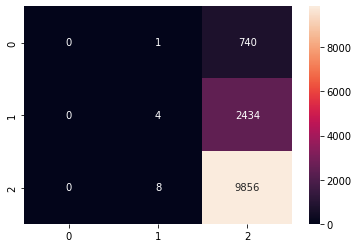

In [68]:
random_model = DecisionTreeClassifier(ccp_alpha=1e-06, max_depth=8, max_features='log2', max_leaf_nodes=20, min_samples_split= 0.1,random_state=100)
model_result(random_model, x_train, y_train, x_test, y_test)

## oversampling

In [27]:
over_best = dt_select(x_ros, y_ros,'accuracy')

print("optimal hyperparameters",over_best.best_params_)
print("optimal accuracy score", over_best.best_score_)
#y_pred=over_best.predict(x_test)
print("test accuracy",over_best.score(x_test,y_test))

optimal hyperparameters {'ccp_alpha': 1e-06, 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_split': 0.1}
optimal accuracy score 0.4330365961059428
test accuracy 0.4513532162845971


Accuracy of Training data:  0.43381801670520903
Accuracy of Testing data:  0.4513532162845971
weigted f1 of Training data:  0.4174361475338298
weigted f1 of Testing data:  0.5196530701155136


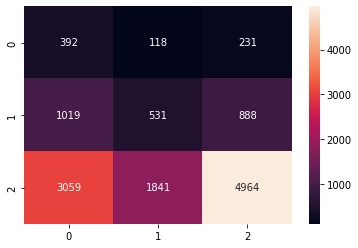

In [ ]:
#accuracy as metric for hyperparamter pruning
over_model = DecisionTreeClassifier(ccp_alpha=1e-06, max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_split= 0.1,random_state=100)
model_result(over_model, x_ros, y_ros, x_test, y_test)

In [69]:
over_best_f1 = dt_select(x_ros, y_ros,'f1_weighted')

print("optimal hyperparameters",over_best_f1.best_params_)
print("optimal accuracy score", over_best_f1.best_score_)
#y_pred=over_best.predict(x_test)
print("test accuracy",over_best_f1.score(x_test,y_test))

optimal hyperparameters {'ccp_alpha': 1e-06, 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_split': 0.2}
optimal accuracy score 0.421665312063899
test accuracy 0.5108025286354237


Accuracy of Training data:  0.4276934773656033
Accuracy of Testing data:  0.4439162769301541
weigted f1 of Training data:  0.4198089021584932
weigted f1 of Testing data:  0.5108025286354237


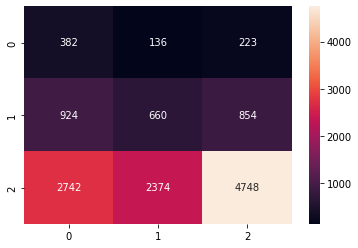

In [71]:
#f1 as metric for hyperparamter pruning
over_model = DecisionTreeClassifier(ccp_alpha=1e-06, max_depth=10, max_features=None, max_leaf_nodes=None, min_samples_split= 0.2,random_state=100)
model_result(over_model, x_ros, y_ros, x_test, y_test)

metric accuracy has better performance

metric f1 score has more balanced result

## undersampling

In [72]:
under_best = dt_select(x_rus, y_rus,'accuracy')
print("optimal hyperparameters",under_best.best_params_)
print("optimal accuracy score", under_best.best_score_)
#y_pred_under=under_best.predict(x_test)
print("test accuracy",under_best.score(x_test,y_test))

optimal hyperparameters {'ccp_alpha': 1e-06, 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_split': 0.1}
optimal accuracy score 0.4214145661174407
test accuracy 0.4458330138771755


Accuracy of Training data:  0.4480090052061348
Accuracy of Testing data:  0.4458330138771755
weigted f1 of Training data:  0.44371474027279645
weigted f1 of Testing data:  0.5119051304664004


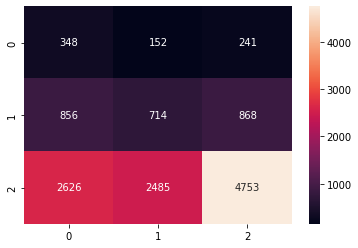

In [ ]:
#accuracy as metric for hyperparamter pruning
under_model = DecisionTreeClassifier(ccp_alpha=1e-06, max_depth=15, max_features=None, max_leaf_nodes=None, min_samples_split= 0.1,random_state=100)
model_result(under_model, x_rus, y_rus, x_test, y_test)

In [73]:
#f1 as score metric
under_best_f1 = dt_select(x_rus, y_rus,'f1_weighted')

print("optimal hyperparameters",under_best_f1.best_params_)
print("optimal f1 score", under_best_f1.best_score_)
print("test f1 score",under_best_f1.score(x_test,y_test))

optimal hyperparameters {'ccp_alpha': 1e-06, 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_split': 0.1}
optimal f1 score 0.4097592041474739
test f1 score 0.5123272413515255


Accuracy of Training data:  0.44955677501055297
Accuracy of Testing data:  0.4467530476117458
weigted f1 of Training data:  0.4457992102992342
weigted f1 of Testing data:  0.5123272413515255


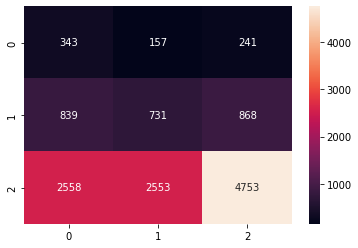

In [95]:
#f1 as metric for hyperparamter pruning
under_model = DecisionTreeClassifier(ccp_alpha=1e-06, max_depth=20, max_features=None, max_leaf_nodes=None, min_samples_split= 0.1,random_state=100)
model_result(under_model, x_rus, y_rus, x_test, y_test)

f1 metric has a slightly better performance 

## SMOTE

In [76]:
#accuracy as metric
smote_best = dt_select(x_smote, y_smote,"accuracy")
print("optimal hyperparameters",smote_best.best_params_)
print("optimal accuracy score", smote_best.best_score_)
print("test accuracy",smote_best.score(x_test,y_test))

optimal hyperparameters {'ccp_alpha': 1e-06, 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_split': 0.1}
optimal accuracy score 0.4556975133197195
test accuracy 0.5261826266963122


Accuracy of Training data:  0.4577353987814279
Accuracy of Testing data:  0.5261826266963122
weigted f1 of Training data:  0.42981785140781087
weigted f1 of Testing data:  0.5711632775579168


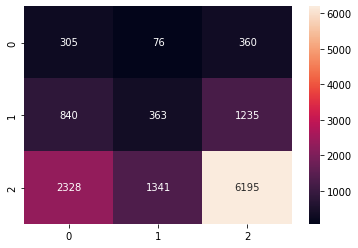

In [90]:
#accuracy as metric for hyperparamter pruning
smote_model = DecisionTreeClassifier(ccp_alpha=1e-06, max_depth=20, min_samples_split= 0.1,max_features=None, max_leaf_nodes= None,random_state=100)
model_result(smote_model, x_smote, y_smote, x_test, y_test)

In [78]:
smote_best_f1 = dt_select(x_smote, y_smote,'f1_weighted')
print("optimal hyperparameters",smote_best_f1.best_params_)
print("optimal f1 score", smote_best_f1.best_score_)
print("test f1 score",smote_best_f1.score(x_test,y_test))

optimal hyperparameters {'ccp_alpha': 1e-06, 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_split': 0.2}
optimal f1 score 0.42849145788284015
test f1 score 0.5144498772570754


Accuracy of Training data:  0.4430153852652031
Accuracy of Testing data:  0.4491298014260523
weigted f1 of Training data:  0.42968144049246615
weigted f1 of Testing data:  0.5144498772570754


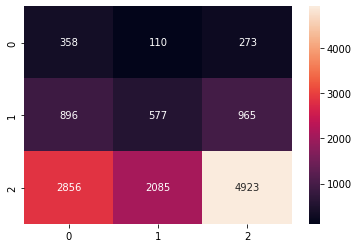

In [97]:
#f1 as metric for hyperparamter pruning
smote_model = DecisionTreeClassifier(ccp_alpha=1e-06, max_depth=20, min_samples_split= 0.2,random_state=100)
model_result(smote_model, x_smote, y_smote, x_test, y_test)

accuracy has a much better performance, thus we may consider using accuracy as the sole metric